### What is this notebook?

This notebook is an easy-to-use interface, wherein you can:
1. Select the Model to run based on (i). Channel number, (ii). History and (iii). Delay.
2. We perform our predictions only on the 193$A$ and 211$A$ channels, so the models corresponding to these images alone are present.
3. Once these three parameters are set, the notebook loads the model weights and the data. 
4. Users are given the model functionality at different cells, which can be run to look at its response.
5. The users can also load their custom data. It is of utmost importance the number of images given by the user corresponds to the history. 
6. The loaded data must be in the form of numpy array -- specifically, of shape `[history,height,width]`, where `height` and `width` are same (a square image). The data is only to be loaded, further processing is taken care of by the notebook.

In [1]:
%matplotlib inline
import tensorflow as tf 
import numpy as np 
import cv2
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams["font.family"]="serif"
%matplotlib inline
import random
#import seaborn as sns
from glob import glob
import sys
import os
#from tensorflow.python.framework import ops
from skimage.exposure import equalize_hist as eqHist
from skimage.filters import gaussian as Gauss
import matplotlib.gridspec as gridspec
from skimage.filters import threshold_otsu as Otsu
from sklearn.mixture import GaussianMixture as GMM
#----------
sys.path.append('../')
from helperfn.utils import *
from helperfn.tf_utils import *
from HSEcalc import *


In [2]:
import sunpy.cm
import datetime

In [9]:
#See which model is around the mean value.
history = 4
delay = 3
ch_filter=193
for cv in np.arange(1,6):
    %run -i Pathfinder_cv.py $history $delay $ch_filter $cv 
    print path_for_model
    strs=path_for_model.split('/')
    tmp = '/'.join(strs[:-2])
    tmp = tmp+'/AE_Predict_ValidCorr'+str(history)+str(delay)+'.txt'
    tmp = np.loadtxt(tmp)
    itno = int(strs[-1].split('-')[-1])
    print tmp[itno]

../Models/WindNet/CrossValidation/193/CV_1/SDOPred43/Model_save/model_no-299
0.4238745323529622
../Models/WindNet/CrossValidation/193/CV_2/SDOPred43/Model_save/model_no-140
0.46467643055327396
../Models/WindNet/CrossValidation/193/CV_3/SDOPred43/Model_save/model_no-240
0.46688325133284536
../Models/WindNet/CrossValidation/193/CV_4/SDOPred43/Model_save/model_no-20
0.3021000757398596
../Models/WindNet/CrossValidation/193/CV_5/SDOPred43/Model_save/model_no-270
0.5524668326892289


### Evaluation models

193A data: <br>
`history=4`, `delay=3`,`cv=5` <br>
211A data: <br>
`history=4`, `delay=3`,`cv=4`4

In [368]:
#Enter the delay and history for selecting the appropriate model
history = 4
delay = 3
ch_filter = 211
cv=4

In [369]:
#Get path for the saved model (a.k.a model checkpoint)
tf.reset_default_graph()
%run -i Pathfinder_cv.py $history $delay $ch_filter $cv 

<Figure size 432x288 with 0 Axes>

In [370]:
print path_for_model

../Models/WindNet/CrossValidation/211/CV_4/SDOPred43/Model_save/model_no-290


In [371]:
%run  -i ModelRestoration_cv.py $history $delay 10 $path_for_model $ch_filter $cv

193
211
Delay: 3
History: 4
N_iterations: 10
../Models/WindNet/CrossValidation/211/CV_4/SDOPred43/Model_save/model_no-290
Data loading started
Data loading: Done
Data Normalization: Done
Data preprocessing: Done
Model definition
INFO:tensorflow:Restoring parameters from ../Models/WindNet/CrossValidation/211/CV_4/SDOPred43/Model_save/model_no-290
(137, 20, 224, 224, 3)
Model definition: Done
Training data reshaped!
Model loading, and dataset preparation is done. Use them in your model now!


In [372]:
'''Plot the predictions.
Prediction corresponds to the prediction on the testing set. 
Prediction2 corresponds to the prediction on the training set.
'''
Prediction = np.reshape(sess.run(WindModel.Regression, feed_dict = {y_stddev:ytest_stddev,keep_prob: 1.0,xprime:FCtest,y:ytest}),[-1,n_out])
Prediction2 = np.reshape(sess.run(WindModel.Regression, feed_dict = {keep_prob: 1.0,xprime:xtrain_condensed,y:ytrain_condensed}),[-1,n_out])

In [373]:
#Generate the dates for data.
_,date_test,_ = BifurcatedDataloader(testpaths,[0,1,2],param_stddev,inshape,True,channelNo)
date_test=np.reshape(date_test,[-1,20,3])
tmp=[]
for i in xrange(date_test.shape[0]):
    for j in xrange(date_test.shape[1]-history-delay+1):
        tmp.append(date_test[i,j+history+delay-1,:])
date_test=np.asarray(tmp)
dt_test=[(datetime.datetime(int(date_test[i,0]),1,1)+datetime.timedelta(int(date_test[i,1])-1)).date() for i in xrange(Prediction.shape[0])]
print date_test.shape
print Prediction.shape
print len(dt_test)

(280, 3)
(280, 1)
280


(280, 1)
(280, 1)
Test observation-prediction correlation: [0.6108557]
Test observation-prediction reduced $\chi^2$:  19.332761375857633
MSE: 76.28390399190431
Training observation-prediction correlation: [0.85594064]
Batchwise correlation:  0.35999165186059456


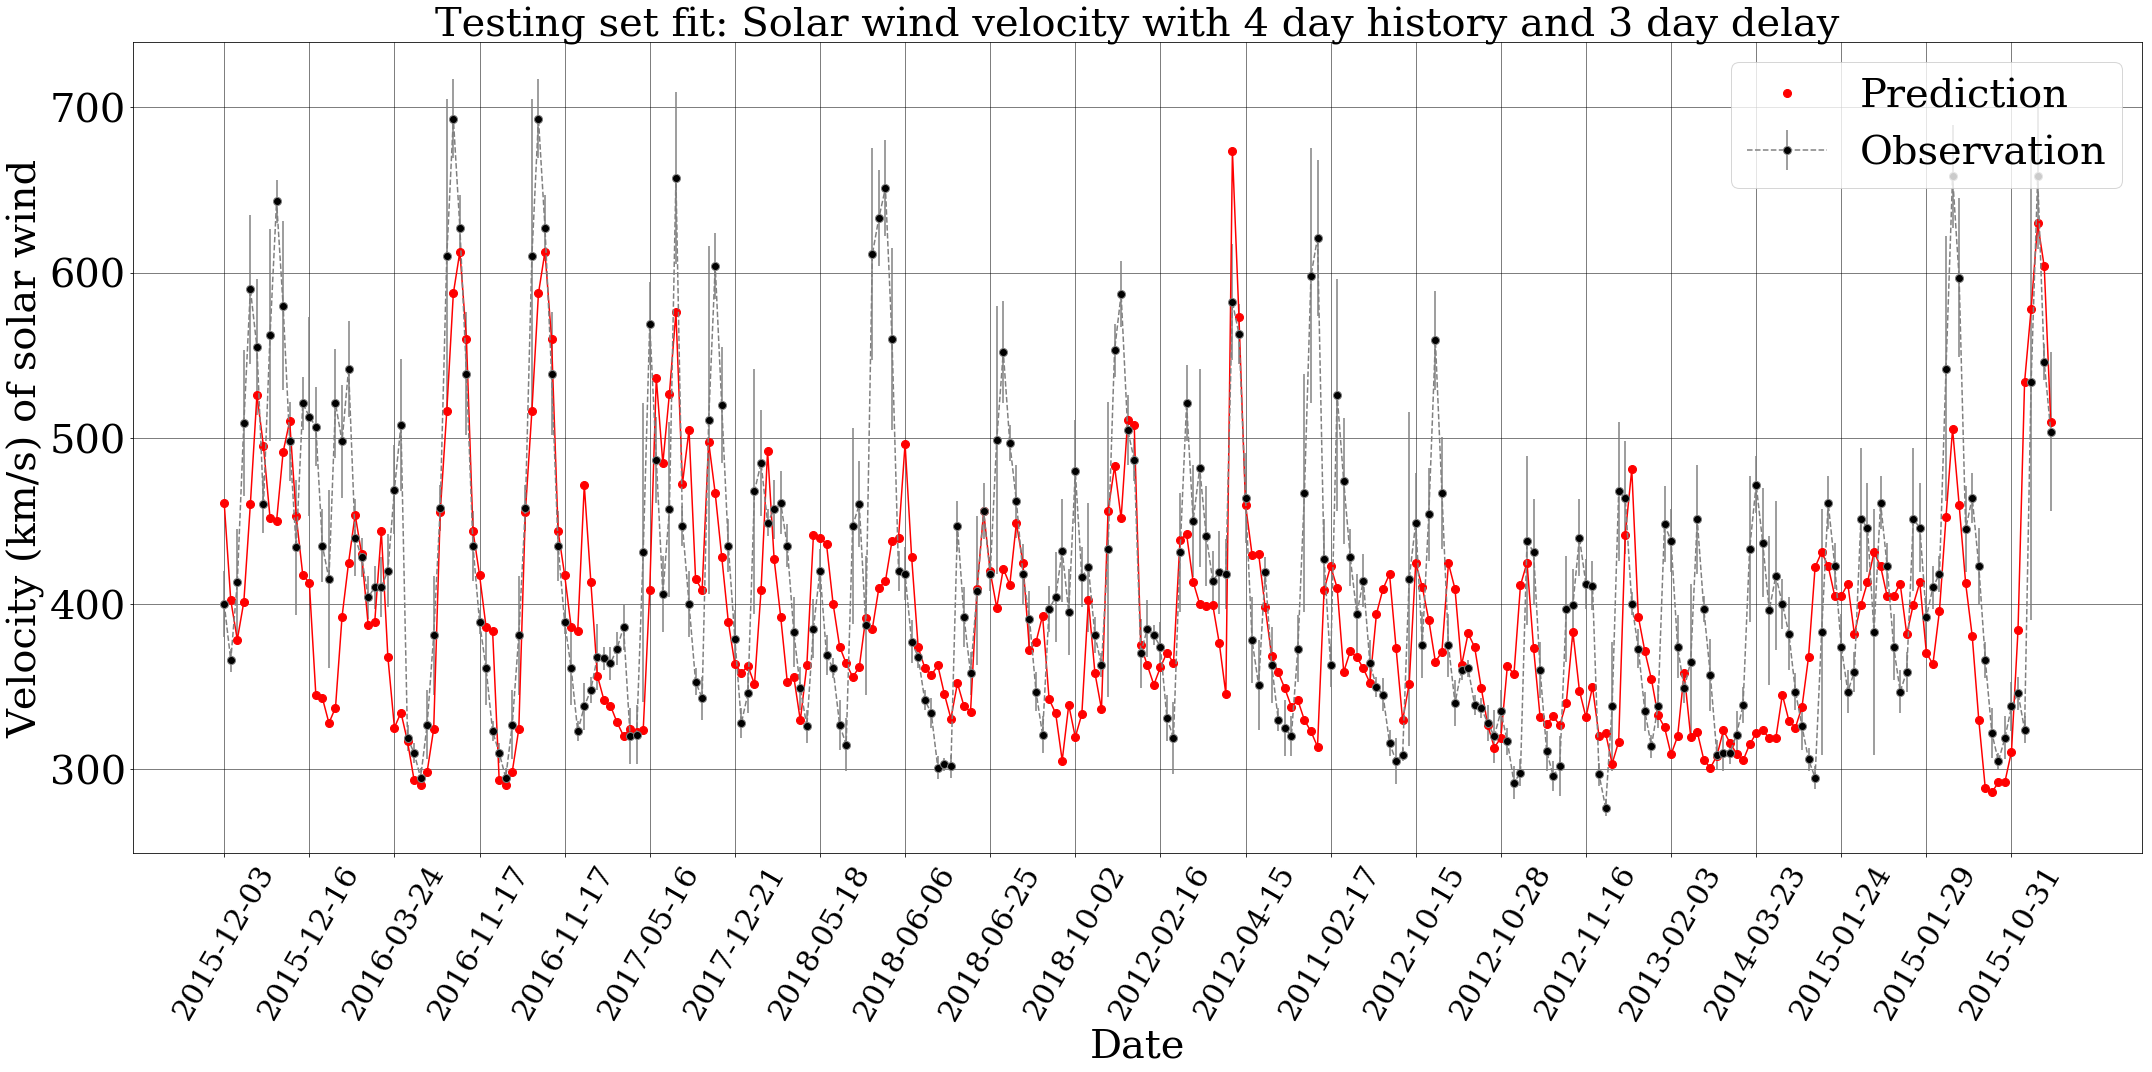

In [374]:
print Prediction.shape
print ytest.shape
print 'Test observation-prediction correlation: ' + str(corr(Prediction[:,0],ytest[:,0]))
print 'Test observation-prediction reduced $\chi^2$: ',
print chi2(Prediction[:,0],ytest[:,0],np.square(ytest_stddev[:,0]))
print "MSE: "+str(np.sqrt(np.mean(np.square(DeNormImage(Prediction,ymin,ymax)-DeNormImage(ytest,ymin,ymax)))))
print 'Training observation-prediction correlation: ' +str(corr(Prediction2[:,0],ytrain_condensed[:,0]))
plt.figure(figsize=(30,15))
#sns.set_style("ticks")
plt.plot(DeNormImage(Prediction,ymin,ymax),'-r')
plt.plot(DeNormImage(Prediction,ymin,ymax),'ro',markersize = 8,label='Prediction')
#plt.plot(DeNormImage(ytest,ymin,ymax),'-g')
#plt.plot(DeNormImage(ytest,ymin,ymax),'go',markersize = 8,label='Observation')
xtmp=np.arange(Prediction.shape[0])
ytmp=DeNormImage(ytest,ymin,ymax)
yertmp = DeNormImage(ytest_stddev,0.0,ymax)
plt.errorbar(xtmp,ytmp,yertmp,linestyle='--',marker='o',markersize = 8,ecolor='grey',mfc='k',color='grey',label='Observation')
plt.xlabel('Date', fontsize = 40)
xtmp2=[]
dt2=[]
axvloc=[]
cor_b=[]
for i in np.arange(0,Prediction.shape[0],20-history-delay):
    cor_b.append(corr(Prediction[i:i+20-history-delay,0],ytest[i:i+20-history-delay,0]))
    xtmp2.append(xtmp[i])
    dt2.append(dt_test[i])
print "Batchwise correlation: ",np.mean(np.asarray(cor_b))
plt.xticks(xtmp2,dt2,fontsize=30,rotation=60)
plt.yticks(fontsize=40)
plt.ylabel('Velocity (km/s) of solar wind', fontsize = 40)
plt.legend(loc='best',fontsize=40)
plt.grid(color='k',linewidth=0.5)
plt.title('Testing set fit: Solar wind velocity with '+ str(history)+' day history and '+str(delay)+' day delay',fontsize=40)
plt.tight_layout()
#plt.savefig('../Plots/BestFitPlot_dated_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'.eps',dpi=400,format='eps')
#plt.savefig('../Plots/BestFitPlot_dated_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'.pdf',dpi=300,format='pdf')

In [375]:
xtmp2=[]
dt2=[]
axvloc=[]
predval=[]
obsval=[]
obsstd=[]
for i in np.arange(0,Prediction.shape[0],20-history-delay+1):
    xtmp2.append(xtmp[i])
    dt2.append(dt_test[i:i+20-history-delay+1])
    predval.append(DeNormImage(Prediction,ymin,ymax)[i:i+20-history-delay+1])
    obsval.append(DeNormImage(ytest,ymin,ymax)[i:i+20-history-delay+1])
    obsstd.append(DeNormImage(ytest_stddev,0.0,ymax)[i:i+20-history-delay+1])
predval.append(DeNormImage(Prediction,ymin,ymax)[i:])
dt2.append(dt_test[i:])
obsval.append(DeNormImage(ytest,ymin,ymax)[i:])
obsstd.append(DeNormImage(ytest_stddev,0.0,ymax)[i:])
print len(dt2)
print ytmp.shape
print yertmp.shape
print len(dt2[0])
print len(obsstd[0])

21
(280, 1)
(280, 1)
14
14


(21, 14)


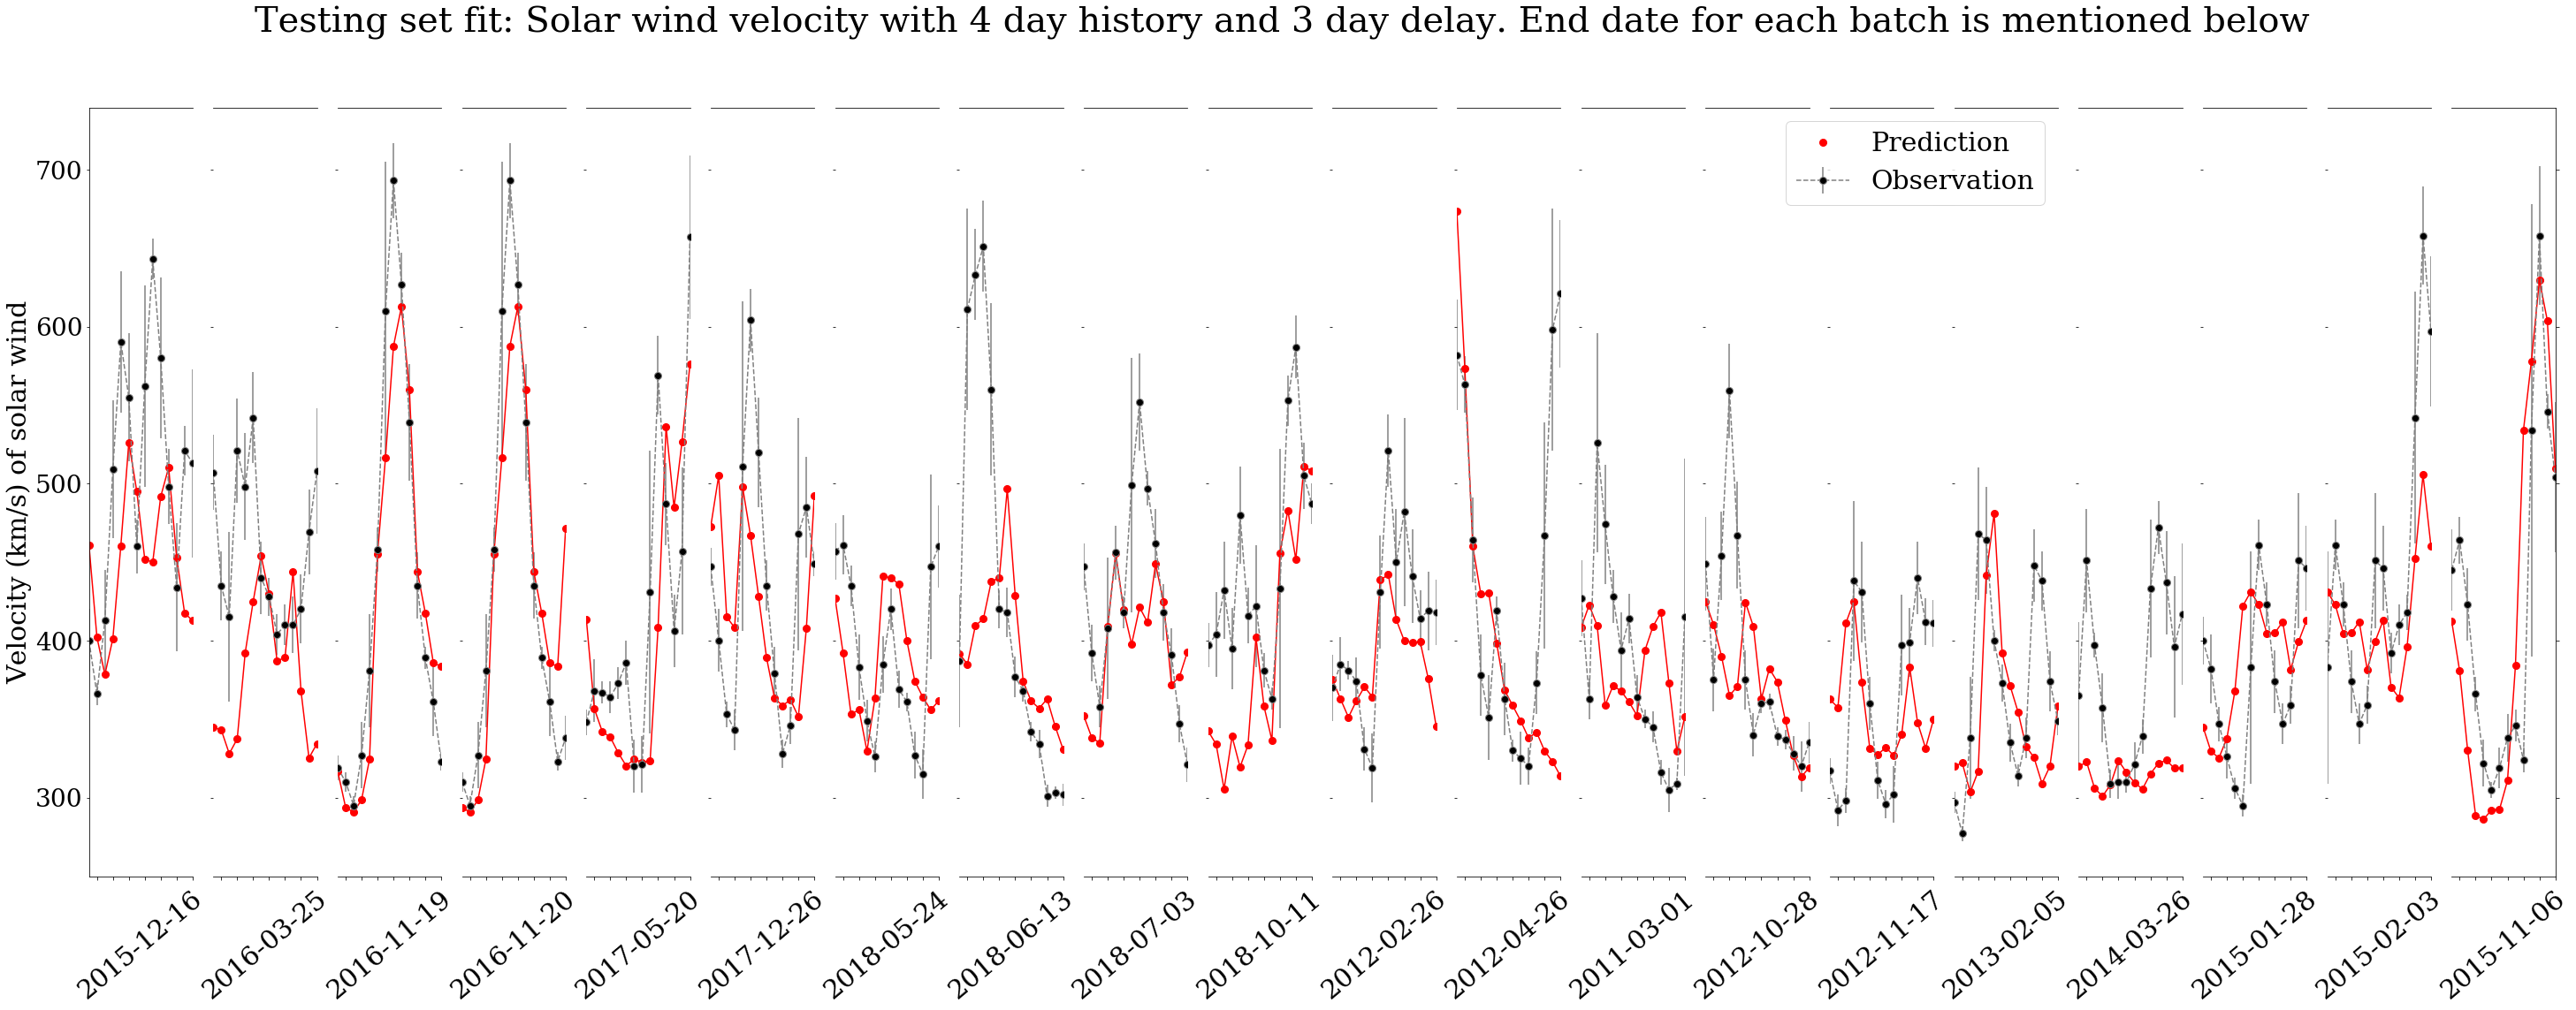

In [376]:
#No of batches
N=len(dt2)-1
arrdt=np.asarray(dt2)
print arrdt.shape
#Plotting prediction
fig,axes = plt.subplots(1, N, sharey=True,figsize=(50,16))
i=0
k=0
for ax in axes:
    if k==15:
        zo=2*N
    else:
        zo=1
    ax.plot(arrdt[k],predval[k],'ro',markersize = 8,label='Prediction',zorder=zo)
    ax.plot(arrdt[k],predval[k],'r',zorder=zo)
    ax.errorbar(arrdt[k],obsval[k],obsstd[k],linestyle='--',marker='o',markersize = 8,ecolor='grey',mfc='k',color='grey',label='Observation',zorder=zo)
    ax.set_xticklabels([])
    ax.set_xlabel(arrdt[k][-1],fontsize=30,rotation=40)
    ax.set_xlim(arrdt[k][0],arrdt[k][-1])
    if k==0:
        ax.yaxis.tick_left()
        ax.tick_params(labeltop=False)
        ax.tick_params('y',labelsize=28)
        ax.set_ylabel('Velocity (km/s) of solar wind', fontsize = 30)
        ax.spines['right'].set_visible(False)
    elif k==(N-1):
        ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(labeltop=False)
    i+=20-history-delay
    k=k+1
    #ax.set_yticks(fontsize=40)
#plt.subplots_adjust(wspace=0.45)
#plt.grid(color='k',linewidth=0.5)
plt.suptitle('Testing set fit: Solar wind velocity with '+ str(history)+' day history and '+str(delay)+' day delay. End date for each batch is mentioned below',fontsize=40)
axes[15].legend(loc='upper right',fontsize=30)
#plt.savefig('../Plots/BestFitPlot_broken_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'.eps',dpi=400,format='eps')
#plt.savefig('../Plots/BestFitPlot_broken_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'.pdf',dpi=300,format='pdf')

In [377]:
def Mark_ge50(sw):
    #Mark all time points which are more than 50 km/s faster than 1 day earlier. 
    sw1=np.zeros(len(sw))
    sw1[1:]=sw[1:]-sw[:-1]
    sw1_50=np.where(sw1 > 50)[0]
    return sw1_50
def Isolated_elim(sw1_50):
    #Eliminate any isolated single data points which are marked.
    #I know this method is dumb, but it works, and I am too lazy. 
    sw2=[]
    i=0
    while i<len(sw1_50)-1:
        if sw1_50[i+1]!=sw1_50[i]+1:
            if i!=0 and sw1_50[i]!=sw1_50[i-1]+1:
                sw2.append(sw1_50[i])
            elif i==0:
                sw2.append(sw1_50[i])
            else:
                pass
        i+=1
    if sw2:
        sw2=sw1_50[np.where(sw1_50!=sw2)]
    else:
        sw2=sw1_50
    return sw2
def Group(sw2):
    #Group each contiguous block of marked points as a distinct high speed enhancement (HSE) 
    sw3=[]
    i=0
    while i<len(sw2)-1:
        start=sw2[i]
        while i<len(sw2)-1:
            if (sw2[i+1]==sw2[i]+1):
                i+=1
            else:
                break
        end=sw2[i]
        i+=1
        sw3.append([start,end])
    return sw3
def Vel_time(sw,sw3):
    #For each HSE, find the minimum speed starting 2 days ahead of the HSE till the start of the HSE, 
    #and mark it as the minimum speed (Vmin) of the HSE; 
    #find the maximum speed starting from the beginning of the HSE through 1 day after the HSE and 
    #mark it as the maximum speed (Vmax) of the HSE. 
    #For each HSE, find the last time reaching Vmin and the first time reaching Vmax 
    #and mark them as the start and end time of an SIR. 
    Velocities=[]
    Times=[]
    if sw3:
        for hse in sw3:
            #try:
            min_index=np.max([0,hse[0]-2])
            max_index=np.min([hse[1]+2,len(sw)])
            vmin_ind=min_index+np.where(sw[min_index:hse[0]+1]==np.min(sw[min_index:hse[0]+1]))[0][-1]
            vmin=sw[vmin_ind]
            vmax_ind=hse[0]+np.where(sw[hse[0]:max_index]==np.max(sw[hse[0]:max_index]))[0][0]
            vmax=sw[vmax_ind]
            Times.append([vmin_ind,vmax_ind])
            Velocities.append([vmin,vmax])
    return Velocities,Times
def Final_vet(sw,Velocities,Times):
    #For the regrouped SIRs, find the Vmin and Vmax for each SIR and mark the last time of highest speed gradient as 
    #the stream interface (SI), the boundary between slow and fast wind
    #Reject any SIRs with Vmin faster than 500 km/s, or Vmax slower than 400 km, or speed increase less than 100 km/s
    SI_times=[]
    Vel_final=[]
    Time_final=[]
    if Times: #can have Velocities also
        for v,ind in zip(Velocities,Times):
            in_0=np.max([0,ind[0]])
            in_1=np.min([ind[1],len(sw)-2])
            grad_loc=np.argmax(sw[in_0+1:in_1+1]-sw[in_0:in_1])
            si=in_0+grad_loc
            if v[0]>500 or v[1]<400 or (v[1]-v[0])<100:#(sw[1:]-sw[:-1])[si]<100:
                pass
            else:
                SI_times.append(si+0.5)
                Vel_final.append(v)
                Time_final.append(ind)
        #print SI_times    
    return Vel_final,Time_final,SI_times
def HSE(sw):
    sw1_50=Mark_ge50(sw)
    sw2=Isolated_elim(sw1_50)
    sw3=Group(sw2)
    Velocities,Times=Vel_time(sw,sw3)
    Vel_final,Time_final,SI_times=Final_vet(sw,Velocities,Times)
    return Vel_final,Time_final,SI_times
def Overlap_comp(ind_sim,obs):
    ind_flag=[]
    for ind in obs:
        overlap=np.min([ind[1],ind_sim[1]])-np.max([ind[0],ind_sim[0]])
        ind_flag.append(overlap)
    return obs[np.argmax(ind_flag)],np.max(ind_flag)
def Compare_sim_obs(sim,obs):
    Vel_sim,Time_sim,SI_sim = HSE(sim)
    Vel_obs,Time_obs,SI_obs = HSE(obs)
    obs_times=[]
    obs_flag=[]
    if Time_sim:
        for times in Time_sim:
            if Time_obs:
                tm,flg=Overlap_comp(times,Time_obs)
                obs_times.append(tm)
                obs_flag.append(flg)
    return np.asarray(obs_times),np.asarray(obs_flag),SI_sim,SI_obs
def BatchwiseHSE(data,history,delay):
    TP=0
    FP=0
    FN=0
    a1=[]
    a2=[]
    a3=[]
    a4=[]
    for i in np.arange(0,data.shape[0],20-history-delay):
        obs_times,obs_flag,t_sim,t_obs=Compare_sim_obs(data[i:i+20-history-delay,1],data[i:i+20-history-delay,0])
        a1.append(obs_times)
        a2.append(obs_flag)
        a3.append(t_sim+i)
        a4.append(t_obs+i)
        tp_batch=len(np.where(obs_flag>0.0)[0])
        TP+=tp_batch
        FN+=len(t_sim)-tp_batch
        FP+=len(t_obs)-tp_batch
    return TP,FP,FN
    

(21, 14)
2015-12-05 2015-12-08 4.5
2016-11-09 2016-11-14 4.5
2016-11-09 2016-11-14 3.5
2017-05-14 2017-05-17 9.5
2017-12-24 2017-12-26 11.5


/usr/lib/python2.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


2015-01-30 2015-02-02 10.5
2015-10-30 2015-11-03 8.5


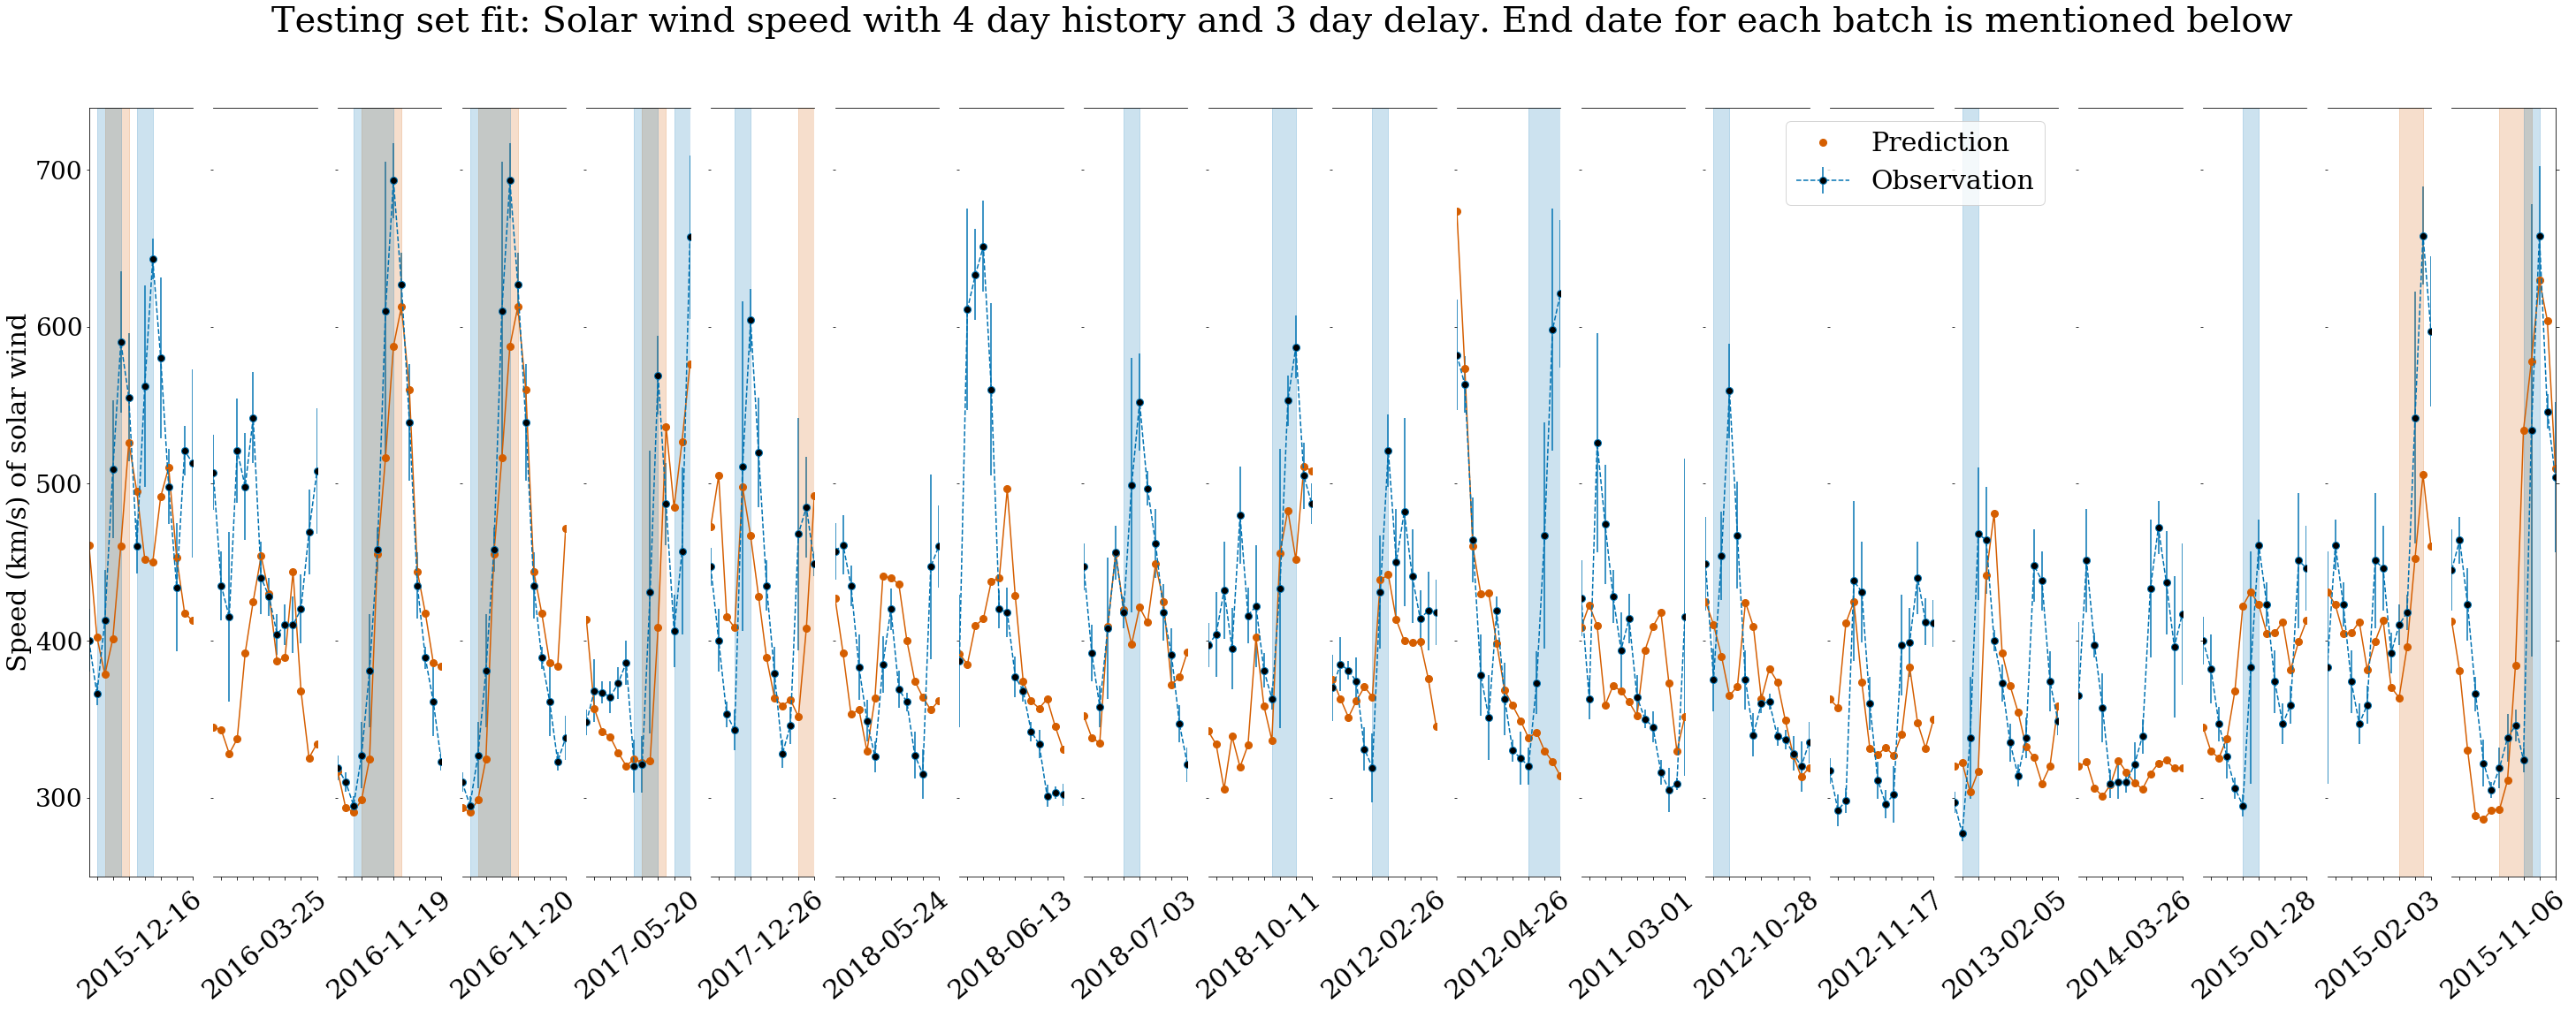

In [378]:
#No of batches
N=len(dt2)-1
arrdt=np.asarray(dt2)
print arrdt.shape
#Plotting prediction
fig,axes = plt.subplots(1, N, sharey=True,figsize=(50,16))
i=0
k=0
col_pred='#d55e00'
col_obs='#0072b2'
for ax in axes:
    if k==15:
        zo=2*N
    else:
        zo=1
    ax.plot(arrdt[k],predval[k],'o',color=col_pred,markersize = 8,label='Prediction',zorder=zo)
    ax.plot(arrdt[k],predval[k],color=col_pred,zorder=zo)
    ax.errorbar(arrdt[k],obsval[k],obsstd[k],linestyle='--',marker='o',markersize = 8,ecolor=col_obs,mfc='k',color=col_obs,label='Observation',zorder=zo)
    ax.set_xticklabels([])
    ax.set_xlabel(arrdt[k][-1],fontsize=30,rotation=40)
    ax.set_xlim(arrdt[k][0],arrdt[k][-1])
    _,time_pred,time_si_pred=HSE(predval[k].ravel())
    _,time_obs,time_si_obs=HSE(obsval[k].ravel())
    
    for r,si in zip(time_pred,time_si_pred):
        print arrdt[k][r[0]],arrdt[k][r[1]],si
        ax.axvspan(arrdt[k][r[0]],arrdt[k][r[1]],color=col_pred,alpha=0.2)
    for r,si in zip(time_obs,time_si_obs):
        ax.axvspan(arrdt[k][r[0]],arrdt[k][r[1]],color=col_obs,alpha=0.2)
    if k==0:
        ax.yaxis.tick_left()
        ax.tick_params(labeltop=False)
        ax.tick_params('y',labelsize=28)
        ax.set_ylabel('Speed (km/s) of solar wind', fontsize = 30)
        ax.spines['right'].set_visible(False)
    elif k==(N-1):
        ax.spines['left'].set_visible(False)
        ax.yaxis.tick_right()
    else:
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.tick_params(labeltop=False)
    i+=20-history-delay
    k=k+1
    #ax.set_yticks(fontsize=40)
#plt.subplots_adjust(wspace=0.45)
#plt.grid(color='k',linewidth=0.5)
plt.suptitle('Testing set fit: Solar wind speed with '+ str(history)+' day history and '+str(delay)+' day delay. End date for each batch is mentioned below',fontsize=40)
axes[15].legend(loc='upper right',fontsize=30)
#plt.savefig('../Plots/BestFitPlot_broken_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'_HSE.eps',dpi=400,format='eps')
#plt.savefig('../Plots/BestFitPlot_broken_cv'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'_HSE.pdf',dpi=300,format='pdf')
plt.savefig('../Plots/APSPM'+str(ch_filter)+str(history)+str(delay)+'_%d'%(cv)+'_HSE.jpg',dpi=100,format='jpg')    

In [379]:
print arrdt[1][:]

[datetime.date(2016, 3, 12) datetime.date(2016, 3, 13)
 datetime.date(2016, 3, 14) datetime.date(2016, 3, 15)
 datetime.date(2016, 3, 16) datetime.date(2016, 3, 17)
 datetime.date(2016, 3, 18) datetime.date(2016, 3, 19)
 datetime.date(2016, 3, 20) datetime.date(2016, 3, 21)
 datetime.date(2016, 3, 22) datetime.date(2016, 3, 23)
 datetime.date(2016, 3, 24) datetime.date(2016, 3, 25)]


Text(0.5,1,'Fit scatter plot of Speed (km/s) Hist-delay: 4, 3')

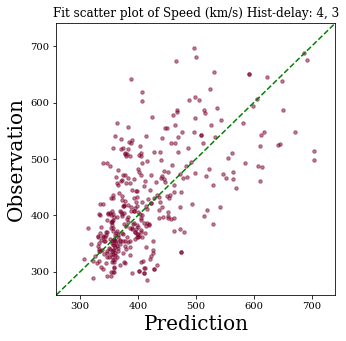

In [295]:
#Scatter plot of prediction and observation
plt.figure(figsize=(5,5))
plt.scatter(DeNormImage(Prediction,ymin,ymax),DeNormImage(ytest,ymin,ymax),c='xkcd:bordeaux',s=12,alpha=0.5)
plt.ylabel('Observation',fontsize=20)
plt.xlabel('Prediction',fontsize=20)
plt.xlim([ymin,ymax+ymin])
plt.ylim([ymin,ymax+ymin])
plt.plot(np.arange(ymin,ymax+ymin+0.1,0.1),np.arange(ymin,ymax+ymin+0.1,0.1),'g--')
plt.title('Fit scatter plot of Speed (km/s) Hist-delay: '+str(history)+', '+str(delay))
#plt.savefig('../Plots/BestFitScatter'+str(history)+str(delay)+'.eps',dpi=400,format='eps')
#plt.savefig('../Plots/BestFitScatter'+str(history)+str(delay)+'.png',dpi=300,format='png')

Text(0.5,1,'Training fit of solar wind with 4 -day history and 3 -day delay')

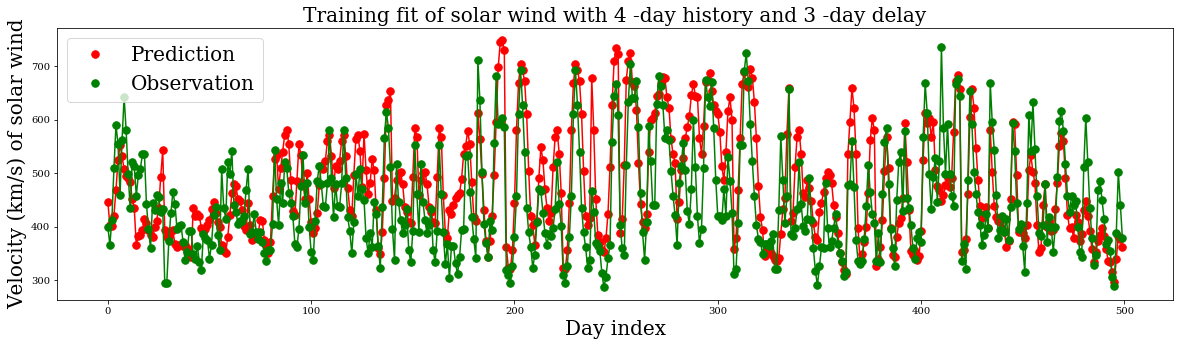

In [296]:
#A representative plot for the training set.
plt.figure(figsize=(20,5))
plt.plot(DeNormImage(Prediction2[:500],ymin,ymax),'r')
plt.plot(DeNormImage(Prediction2[:500],ymin,ymax),'.r',markersize = 15,label='Prediction')
plt.plot(DeNormImage(ytrain_condensed[:500],ymin,ymax),'g')
plt.plot(DeNormImage(ytrain_condensed[:500],ymin,ymax),'.g',markersize = 15,label='Observation')
plt.xlabel('Day index', fontsize = 20)
plt.ylabel('Velocity (km/s) of solar wind', fontsize = 20)
plt.legend(loc='best',fontsize=20)
plt.title('Training fit of solar wind with '+ str(history)+' -day history and '+str(delay)+' -day delay',fontsize=20)

In [380]:
'''
    Evaluate the Gradcam tensors, and keep them ready for session to run!
'''
WindModel.GradCam()

(?, 1, 1, 832)
(?, 56, 56, 64)
(?, 64)
(?, 14, 14, 512)
(?, 512)
(?, 28, 28, 256)
(?, 256)


In [381]:
pred=DeNormImage(Prediction2,ymin,ymax)
print np.where(pred>=600.0)[0]
print np.where(pred<=320.0)[0]
print Prediction2[np.where(pred<=320.0)[0]]
print ytrain_condensed[np.where(pred<=320.0)[0]]

[  20  179  193  205  251  255  256  266  267  275  278  279  305  306
  307  312  313  314  315  316  322  323  324  334  335  341  342  343
  358  378  379  380  381  397  398  399  472  480  481  501  502  508
  518  519  529  537  566  567  880  881  903  904  910  928  929  930
  948  949 1069 1654 1655 1656 1737 1738 1761 1785 1786 1810 1893 1894
 1895]
[ 191  203  210  211  212  213  214  231  232  233  234  235  236  237
  238  239  240  241  265  299  300  301  302  330  331  332  374  375
  376  377  392  432  433  489  578  579  596  605  707  743  744  747
  753  766  774  775  776  777  778  784  785  786  789  794  797  800
  801  809  810  811  812  813  814  815  816  817  818  822  823  824
  826  827  828  829  830  891  892  893  894  895  896  897  898  899
  900  992 1018 1028 1029 1030 1040 1042 1043 1044 1045 1046 1047 1048
 1052 1057 1058 1059 1063 1076 1088 1089 1090 1091 1092 1093 1094 1095
 1096 1097 1099 1123 1127 1159 1160 1161 1201 1202 1203 1226 1229 1230

In [382]:
print xtest.shape
print ytest.shape

(1120, 224, 224, 3)
(280, 1)


In [383]:
#First, we need the date of predictions:
_,date_yr,_ = BifurcatedDataloader(trainpaths,0,param_stddev,inshape,True,channelNo)
_,date_mth,_ = BifurcatedDataloader(trainpaths,1,param_stddev,inshape,True,channelNo)
date_train=np.concatenate((date_yr,date_mth),axis=2)
print date_train.shape
tmp=[]
tmp2=[]
for i in xrange(date_train.shape[0]):
    for j in xrange(date_train.shape[1]-delay-history+1):
        tmp2.append(date_train[i,j:j+history,:])
        tmp.append(date_train[i,j+history+delay-1,:])
date_train=np.asarray(tmp)
date_train2=np.asarray(tmp2)
print date_train.shape
print date_train2.shape

(137, 20, 2)
(1918, 2)
(1918, 4, 2)


In [393]:
"""
    This is to find the exact images corresponding to the 211 data we have courtesy refree report. 
"""
ind=np.where(date_train[:,0]==2012)[0]
val=np.where(date_train[ind,1]==154)
print date_train[ind[val]]
print ind[val]

[[2012.  154.]]
[925]


In [394]:
'''
    Evaluate the grad cam maps for all values in the training set. Training set is used as it is fitted well (obviously),
    and hence gives more confidence to our stochastic result shown later on.
'''
xt =np.reshape(xtrain_historied,[-1,history,224,224,3])
GC_total=[]
index = 925
tmp=np.reshape(xt[index,:,:,:,:],[-1,224,224,3])
print pred[index]
#Get embeddings
Emb = WindModel.GetEmbedding(tmp)
#Reshape embedding appropriately.
Emb = np.reshape(Emb,[-1,history,WindModel.endshp])
'''
    Grad cam can be looked at in the raw form, or with some transformation. Negative grad cam values don't make
    much sense, so while we can understand the negative values to contribute to reducing the regressed value,
    I provide space for open interpretation here. 

    I use the raw grad cam values, but the positive values alone would also make the same sense. Negative, absolute
    scaled and squared values are provided for completeness.
'''
for iden in ['_pos_']:
    Map = WindModel.GetGradCam(tmp,Emb)
    if iden=='_pos_':
        Map=(np.abs(Map)+Map)/2.0
    elif iden=='_neg_':
        Map=(np.abs(Map)-Map)/2.0
    elif iden=='_scale_':
        Map = (Map-np.min(Map))/(np.max(Map)-np.min(Map))
    elif iden=='_square_':
        Map=np.square(Map)
    elif iden=='_inv_':
        Map=Map+np.abs(Map)
        Map = (Map-np.min(Map))/(np.max(Map)-np.min(Map))
        Map = 1.0/(Map+1e-2)
    else:
        Map=Map
    GC_total.append(Map)
GC_total = np.asarray(GC_total)
print np.max(Map)
print np.min(Map)
print GC_total.shape

[331.72588618]
0.14861305
0.0
(1, 1, 4, 224, 224)


In [395]:
#For plotting, we also need the date of the map. Thus, obtain the prediction date:
pred_date=date_train[index,:].astype(int)
dt=[(datetime.datetime(date_train2[index][i][0].astype(int),1,1)+datetime.timedelta(date_train2[index][i][1]-1)).date() for i in np.arange(history)]
print dt
dt2=(datetime.datetime(pred_date[0],1,1)+datetime.timedelta(pred_date[1]-1)).date()
print datetime.datetime(pred_date[0],1,1)
print datetime.timedelta(pred_date[1]-1)
print pred_date[1]-1
print dt2

[datetime.date(2012, 5, 27), datetime.date(2012, 5, 28), datetime.date(2012, 5, 29), datetime.date(2012, 5, 30)]
2012-01-01 00:00:00
153 days, 0:00:00
153
2012-06-02


(2, 4)
Min value in _pos_is: 0.0
Max value in _pos_is: 0.14861305


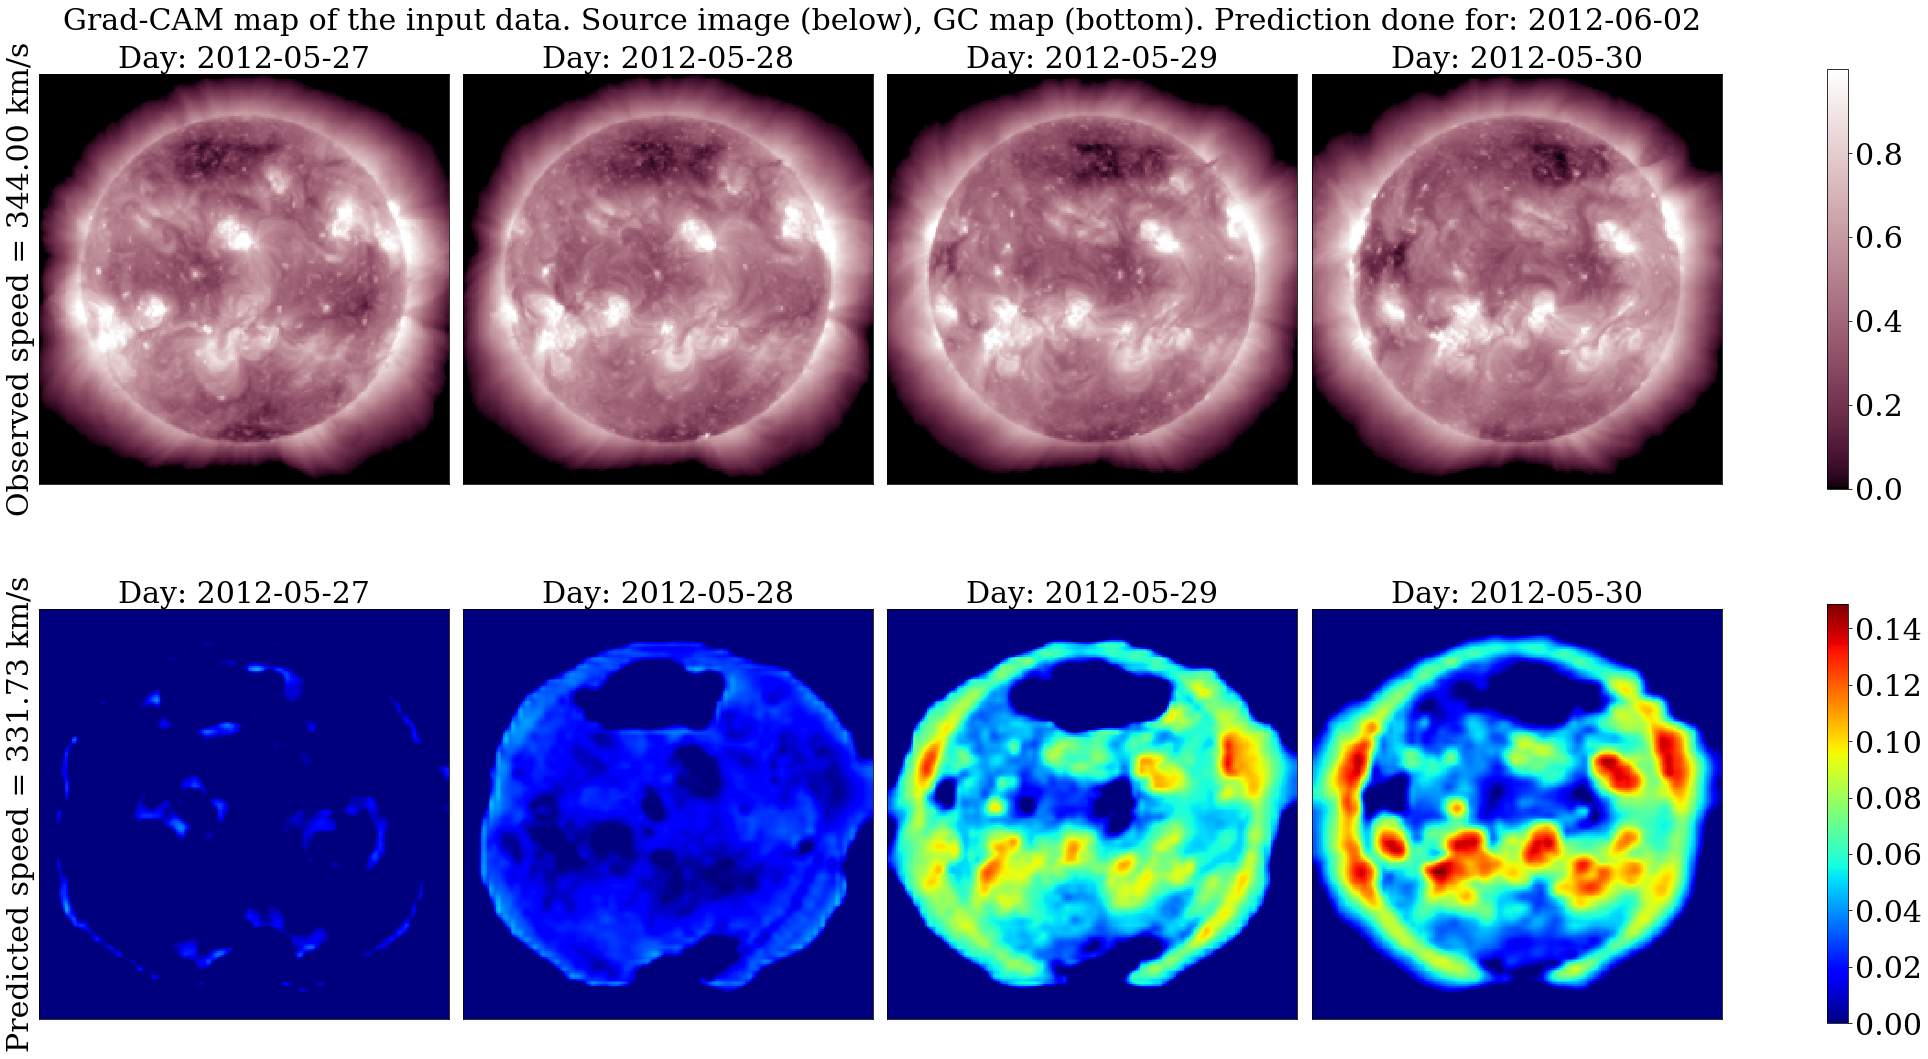

In [397]:
'''
    Uncomment below to display any gradcam map
'''
ob_tmp=DeNormImage(ytrain_condensed,ymin,ymax)
#Normalize images to get correct cmaps.
tmp2 = tmp[:,:,:,0]
tmp2 = (tmp2-np.min(tmp2))/(np.max(tmp2)-np.min(tmp2)+1e-3)
tmp3=GC_total[0,0,:,:,:]
#tmp3=(tmp3-np.min(tmp3))/(np.max(tmp3)-np.min(tmp3)+1e-3)
fig,axes=plt.subplots(nrows=2,ncols=history,figsize=(30,15))
print axes.shape
labels=['Observed speed = %0.2f km/s'%(ob_tmp[index]),'Predicted speed = %0.2f km/s'%(pred[index])]
plt.suptitle('Grad-CAM map of the input data. Source image (below), GC map (bottom). Prediction done for: '+str(dt2),x=0.41,y=1.0,fontsize=30)
for ax,i in zip(axes[:,0],xrange(2)):
    ax.set_ylabel(labels[i],rotation = 90,fontsize=30)
i=0
im1=[]
for ax in axes[0].flat:
    im1= ax.imshow(tmp2[i,:],origin='lower',cmap='sdoaia'+str(ch_filter),clim=(np.min(tmp2),np.max(tmp2)))
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
i=0
im2=[]
for ax in axes[1].flat:
    mp = Map
    im2 = ax.imshow((tmp3[i,:,:]),origin='lower',cmap='jet',clim=(np.min(mp),np.max(mp)))
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
plt.tight_layout()
cb1=fig.colorbar(im1, ax=axes[0].ravel().tolist())
cb1.ax.tick_params(labelsize=30)
cb2=fig.colorbar(im2, ax=axes[1].ravel().tolist())
cb2.ax.tick_params(labelsize=30)

print "Min value in " + iden+ "is: " + str(np.min(Map))
print "Max value in " + iden+ "is: " + str(np.max(Map))

plt.savefig('../Plots/Gradcam_dated_test_'+str(ch_filter)+str(history)+str(delay)+str(cv)+'_'+str(index)+iden+'.pdf',dpi=300,format='pdf')
plt.savefig('../Plots/Gradcam_dated_test_'+str(ch_filter)+str(history)+str(delay)+str(cv)+'_'+str(index)+iden+'.eps',dpi=400,format='eps')

### Trying out integrated gradients
For a baseline image $x_0$, we have: $$y=x_0+\alpha*(x-x_0),$$ the interpolated image, and we have the integrated gradient as $$\phi(\alpha_i,x,y)=\int_{\alpha=0}^{\alpha_i}(x-x_0)Grad(f(y),x) d\alpha$$

In [285]:
def Grad(WindModel):
    Reg_B_grad = tf.reshape(Saliency(WindModel.Regression,WindModel.xprime,WindModel.sess),[-1,WindModel.endshp])
    #We have the gradient of LSTM part. Now we need gradient of the FClayer part.    
    for i in xrange(WindModel.FClayer.get_shape().as_list()[-1]):
        tmp=Saliency(WindModel.FClayer[:,i],WindModel.x,WindModel.sess)
        if i%100==0:
            print i
        tmp=tf.multiply(tmp,tf.reshape(Reg_B_grad[:,i],[1,-1,1,1,1]))
        try:
            Gradients+=tmp
            if i%100==0:
                print "Lol"
        except:
            Gradients=tmp
            print "Lolwa"
    return Gradients    
def phi_1(x,x_0,alpha,Gradient,WindModel):
    tmpx=x-x_0
    y=x_0+alpha*(tmpx)
    y=np.reshape(y,[-1,224,224,3])
    emb=WindModel.GetEmbedding(y).reshape([-1,history,832]).astype(np.float32)
    speed=np.reshape(sess.run(WindModel.Regression, feed_dict = {keep_prob: 1.0,xprime:emb}),[-1,n_out])
    tmp=sess.run(Gradient,feed_dict={WindModel.x:y.astype(np.float32),WindModel.xprime:emb,WindModel.keep_prob:1.0})
    return tmp*tmpx,speed
def PHI(x,x_0,alpha,dalpha,Gradient,WindModel):
    int_gradients=[]#np.zeros([history,224,224,3]).astype(np.float32)
    speed=[]
    for a in np.arange(0,alpha+dalpha,dalpha):
        g,s=phi_1(x,x_0,a,Gradient,WindModel)
        int_gradients.append(g.reshape([-1,224,224,3])*dalpha)
        speed.append(s)
    return int_gradients,speed
        

In [77]:
G=Grad(WindModel)

0
Lolwa
100
Lol
200
Lol
300
Lol
400
Lol
500
Lol
600
Lol
700
Lol
800
Lol


In [292]:
index = 210
tmp=np.reshape(xt[index,:,:,:,:],[-1,224,224,3])
G2=tf.reshape(G,[-1,224,224,3])

In [293]:
x0=np.random.uniform(np.min(tmp),np.max(tmp),[1,history,224,224,3])
alpha=1.0

181.13826419251114 181.138335676509


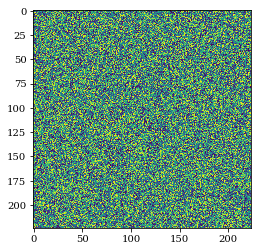

In [294]:
plt.imshow(x0[0,0,:,:,0])
print np.max(x0),np.max(tmp)

In [295]:
phi3,sw3=PHI(tmp,x_0,1.0,0.2,G2,WindModel)
#phi_partial=phi_1(tmp,x0,alpha,G2,WindModel)


In [296]:
phi=[]
for i in xrange(len(phi3)):
    phi.append(np.sum(phi3[:i+1],axis=0))

In [297]:
def LM(t):
    return np.sign(t)*np.log10(np.square(t))

In [298]:
print len(sw3)
ind=-1
print DeNormImage(sw3[ind],ymin,ymax),pred[index]
tmp3=np.cbrt(np.sum(np.abs(phi[ind]),axis=-1)).reshape([-1,224,224])#phi_partial.reshape([-1,224,224,3])
Map=tmp3

6
[[743.77341712]] [743.7733593]


(2, 4)
Min value in _pos_is: 0.0012761082777216308
Max value in _pos_is: 0.3500926848923945


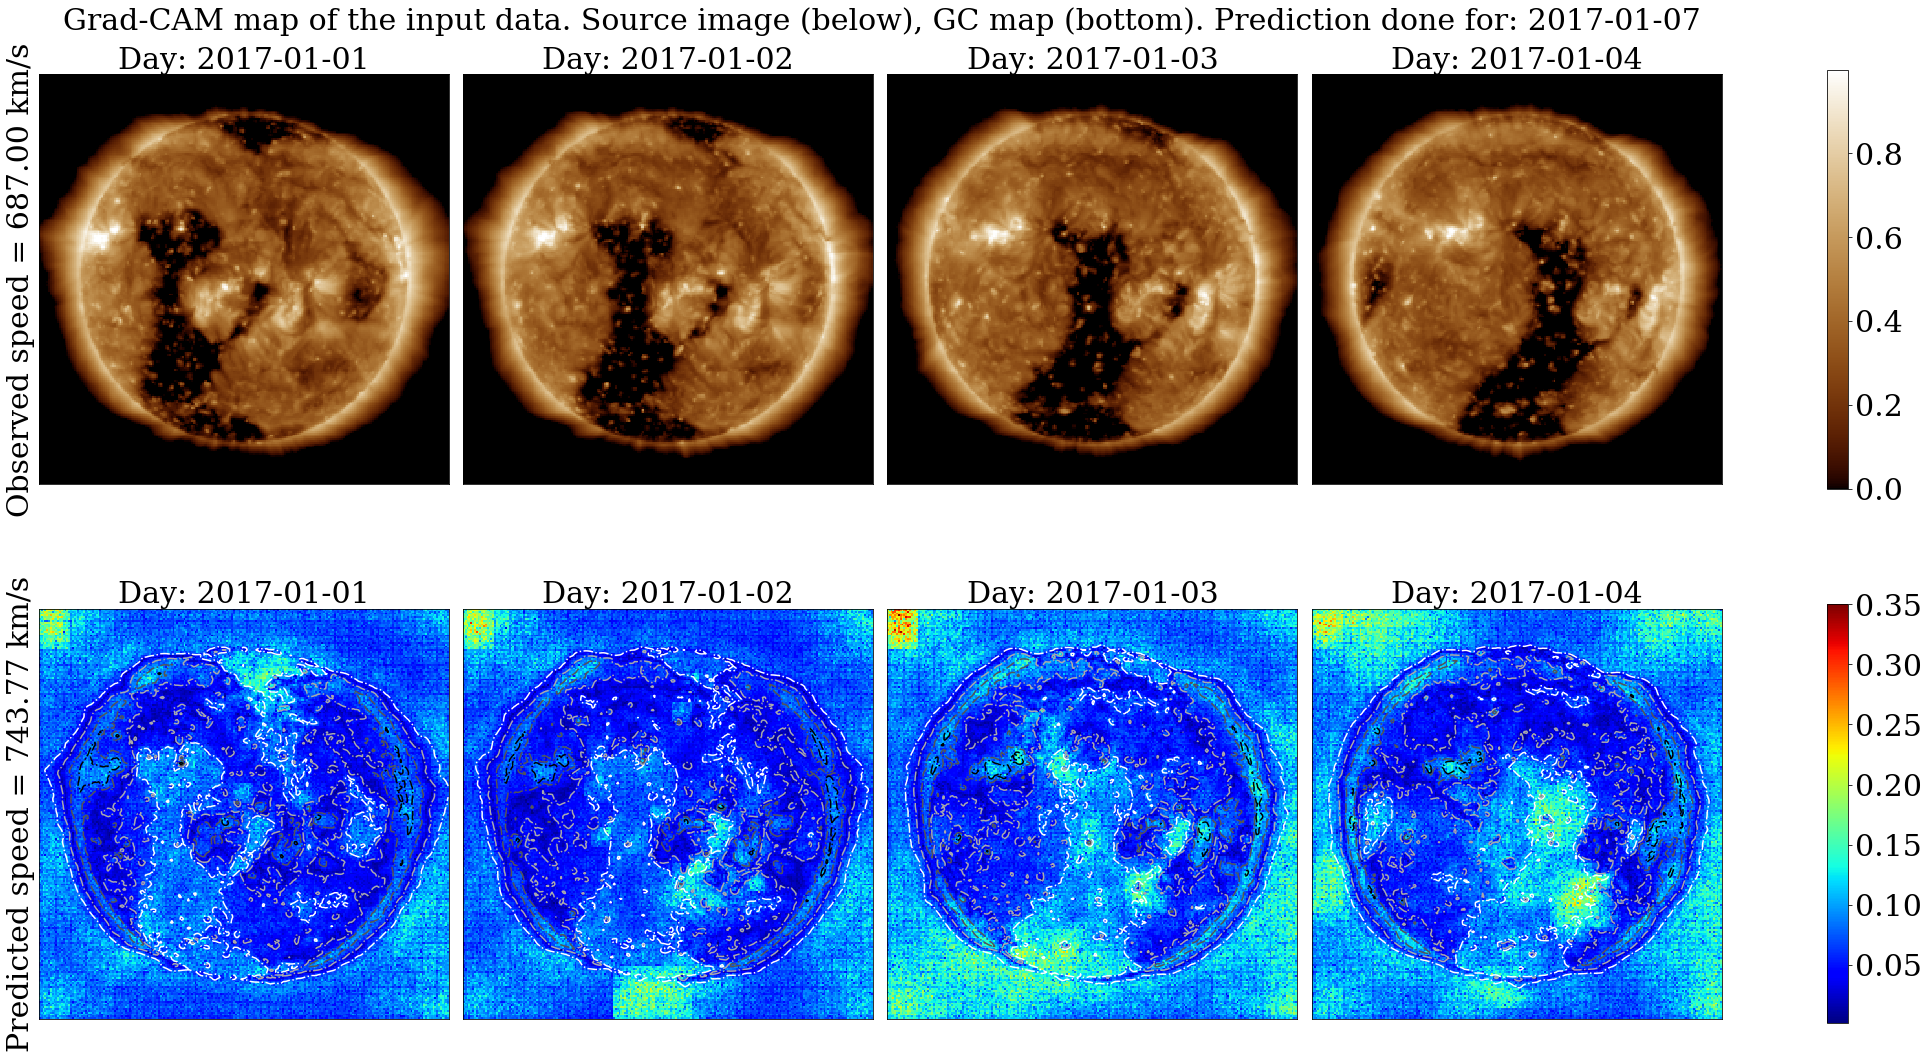

In [300]:
fig,axes=plt.subplots(nrows=2,ncols=history,figsize=(30,15))
print axes.shape
tmpx=tmp-x_0
y=x_0+alpha*(tmpx)
y=np.reshape(y,[-1,224,224,3])
tmp2 = y[:,:,:,0]#tmp[:,:,:,0]
tmp2 = (tmp2-np.min(tmp2))/(np.max(tmp2)-np.min(tmp2)+1e-3)
labels=['Observed speed = %0.2f km/s'%(ob_tmp[index]),'Predicted speed = %0.2f km/s'%(pred[index])]
plt.suptitle('Grad-CAM map of the input data. Source image (below), GC map (bottom). Prediction done for: '+str(dt2),x=0.41,y=1.0,fontsize=30)
for ax,i in zip(axes[:,0],xrange(2)):
    ax.set_ylabel(labels[i],rotation = 90,fontsize=30)
i=0
im1=[]
for ax in axes[0].flat:
    im1= ax.imshow(tmp2[i,:],origin='lower',cmap='sdoaia'+str(ch_filter),clim=(np.min(tmp2),np.max(tmp2)))
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
i=0
im2=[]
for ax in axes[1].flat:
    mp = Map
    im2 = ax.imshow((tmp3[i,:,:]),origin='lower',cmap='jet',clim=(np.min(mp),np.max(mp)))
    ax.contour(tmp2[i,:],5,cmap='gray_r',linestyles='-.')
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
plt.tight_layout()
cb1=fig.colorbar(im1, ax=axes[0].ravel().tolist())
cb1.ax.tick_params(labelsize=30)
cb2=fig.colorbar(im2, ax=axes[1].ravel().tolist())
cb2.ax.tick_params(labelsize=30)

print "Min value in " + iden+ "is: " + str(np.min(Map))
print "Max value in " + iden+ "is: " + str(np.max(Map))


(2, 4)
Min value in _pos_is: -20.869293
Max value in _pos_is: 20.031788


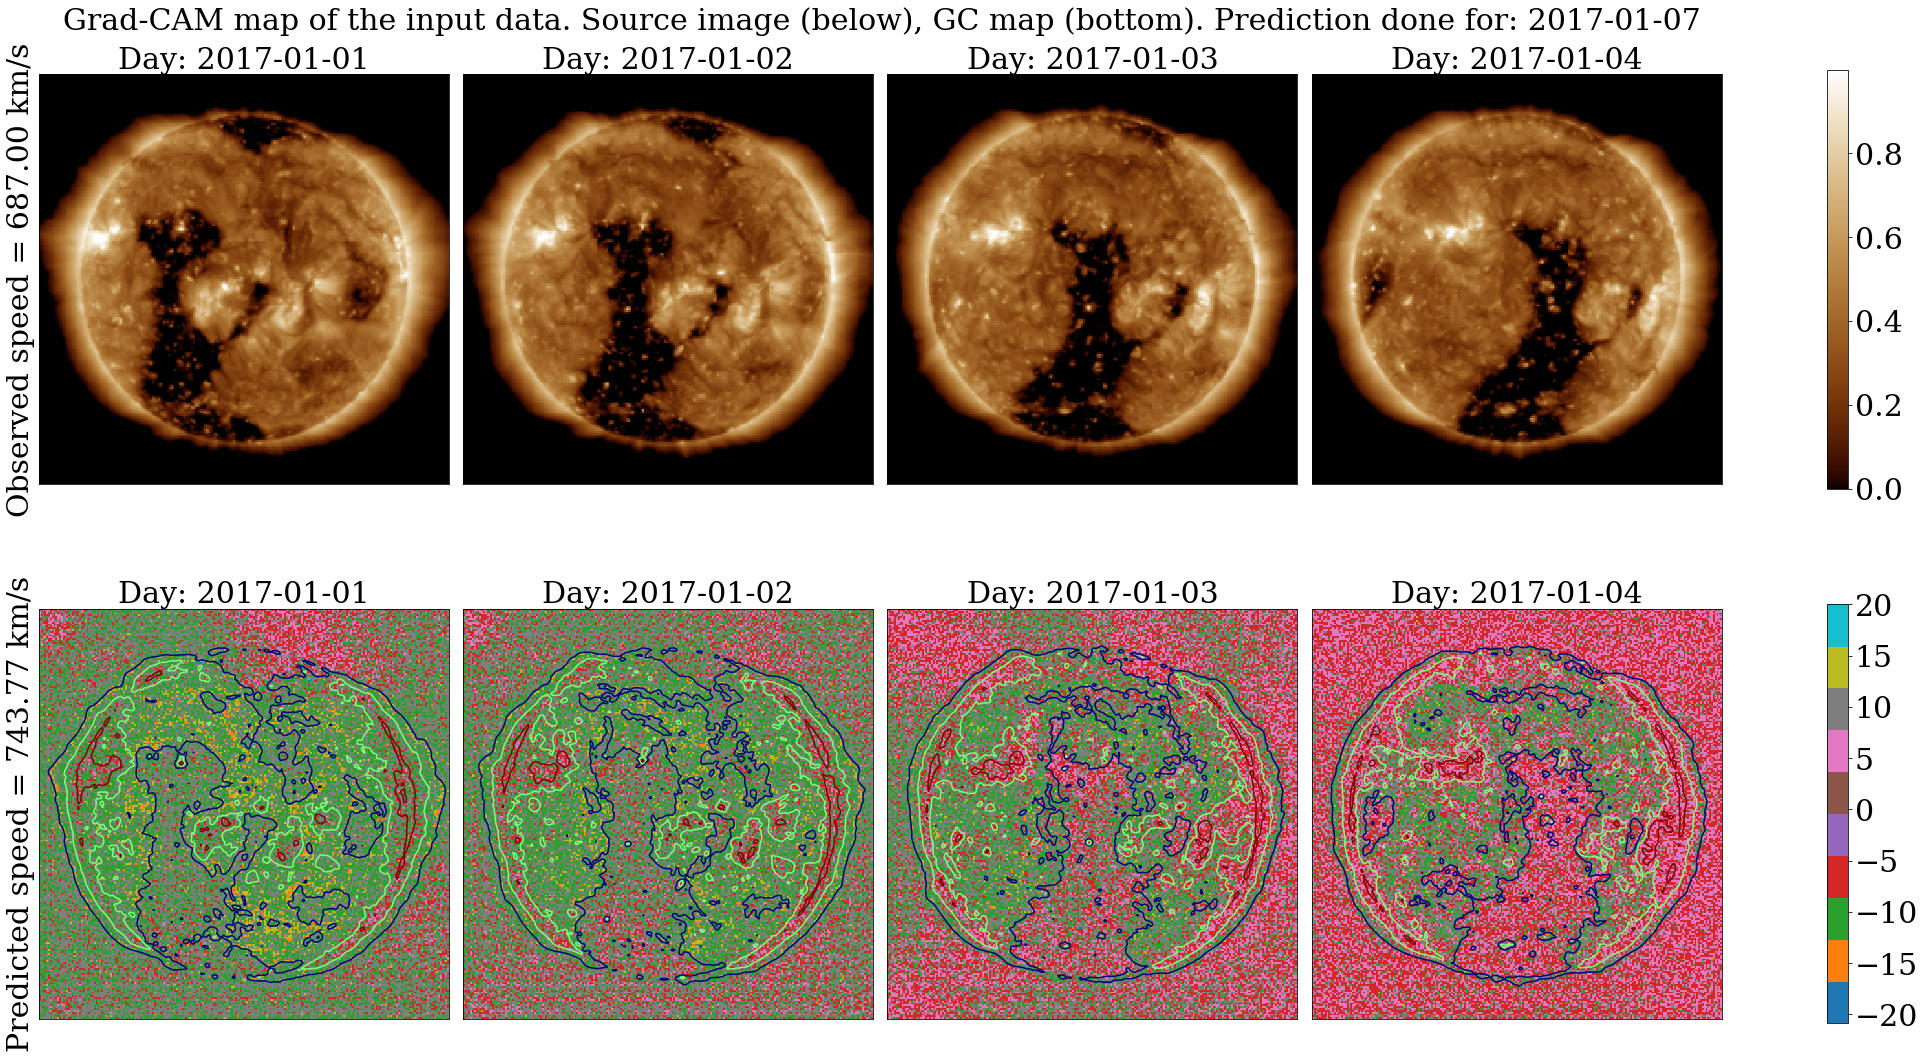

In [182]:
fig,axes=plt.subplots(nrows=2,ncols=history,figsize=(30,15))
print axes.shape
#tmpx=tmp-x_0
#y=x_0+alpha*(tmpx)
#y=np.reshape(y,[-1,224,224,3])
tmp2 = tmp[:,:,:,0]#tmp[:,:,:,0]
tmp2 = (tmp2-np.min(tmp2))/(np.max(tmp2)-np.min(tmp2)+1e-3)
labels=['Observed speed = %0.2f km/s'%(ob_tmp[index]),'Predicted speed = %0.2f km/s'%(pred[index])]
plt.suptitle('Grad-CAM map of the input data. Source image (below), GC map (bottom). Prediction done for: '+str(dt2),x=0.41,y=1.0,fontsize=30)
for ax,i in zip(axes[:,0],xrange(2)):
    ax.set_ylabel(labels[i],rotation = 90,fontsize=30)
i=0
im1=[]
for ax in axes[0].flat:
    im1= ax.imshow(tmp2[i,:],origin='lower',cmap='sdoaia'+str(ch_filter),clim=(np.min(tmp2),np.max(tmp2)))
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
i=0
im2=[]
for ax in axes[1].flat:
    mp = Map
    im2 = ax.imshow((tmp3[i,:,:]),origin='lower',cmap='tab10',clim=(np.min(mp),np.max(mp)))
    ax.contour(tmp2[i,:],3,cmap='jet')
    ax.set_title('Day: '+str(dt[i]),fontsize=30)
    ax.set_xticks([])
    ax.set_yticks([])
    i=i+1
plt.tight_layout()
cb1=fig.colorbar(im1, ax=axes[0].ravel().tolist())
cb1.ax.tick_params(labelsize=30)
cb2=fig.colorbar(im2, ax=axes[1].ravel().tolist())
cb2.ax.tick_params(labelsize=30)

print "Min value in " + iden+ "is: " + str(np.min(Map))
print "Max value in " + iden+ "is: " + str(np.max(Map))
